In [ ]:
#@title @Author and building @date
!pip install watermark
%load_ext watermark
from IPython.display import clear_output;clear_output()
%watermark -a "Romell D.Z." -u -d -p tweepy,scipy,nltk,gensim,sklearn,networkx,textblob,spacy

Romell D.Z. 
last updated: 2020-10-09 

tweepy 3.6.0
scipy 1.4.1
nltk 3.2.5
gensim 3.6.0
sklearn 0.0
networkx 2.5
textblob 0.15.3
spacy 2.2.4


In [ ]:
#@title Parameters
KEYWORD='podemos' #@param {type: "string"}
#@title 
NUMBER_OF_TWEETS = 250  #@param {type: "slider", min: 250, max: 5000, step:250}
language = "es" #@param ["es", "en"] {allow-input: false}
GEO_LOCATION_BOUNDING_BOX = [-82.1,-18.4,-68.3,-3.1] #@param {type: "string"}

In [ ]:
#@title Insert your gist which contains .netrc
%%capture
gist = '' #@param {type: "string"}
!wget https://gist.githubusercontent.com/romellfudi/{gist}/raw/.netrc
file = ".netrc" if os.path.isfile(".netrc") else None
auth = netrc.netrc(file)
ckey,_,csecret=auth.authenticators('tweet_api')
atoken,_,asecret=auth.authenticators('tweet_secret')

In [ ]:
#@title Load libraries
%%capture
!pip install unidecode pyLDAvis pyprind networkx advertools
!pip install deplacy
if language == 'en':
  !python -m spacy download en_core_web_sm
else:
  !python -m spacy download es_core_news_sm
!mkdir snapshot/
import os
import tweepy
from tweepy import Stream
import netrc
from unidecode import unidecode
import re
from tweepy import StreamListener
from pprint import pprint
import pyprind
import pandas as pd
import random
from scipy.stats import beta as beta_distribution
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

from gensim.models.ldamodel import LdaModel
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from textblob import Word
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import advertools as adv
import networkx as nx
import warnings
warnings.simplefilter('ignore')
import pkg_resources,imp
imp.reload(pkg_resources)
import spacy
from spacy import displacy
if language == 'en':
  nlp = spacy.load('en_core_web_sm') 
else:
  nlp = spacy.load('es_core_news_sm')
nltk.download('punkt')
%matplotlib inline
# from textblob import TextBlob
# TextBlob("bonjour esto es una 我 它").detect_language()

# [BoundingBox](https://boundingbox.klokantech.com/) CSV RAW

In [ ]:
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [ ]:
class FiniteStreamListener(StreamListener):
    
    def __init__(self, number_of_tweets):
        self.number_of_tweets = number_of_tweets
        self.tweets = []
        self.tweets_dict = []
        pbar = pyprind.ProgBar(number_of_tweets)
        super(FiniteStreamListener,self).__init__()
        
    def on_status(self, status):
        if len(self.tweets) < self.number_of_tweets:
            # if TextBlob(status.text).detect_language() == 'es':
            self.tweets_dict.append(status._json)
            place = status._json['place']['name'] if(status._json['place']) else ""
            self.tweets.append({'date':status.created_at,
                                'text':status.text,
                                'location':place,
                                'followers':status._json['user']['followers_count']})
            pbar.update()
        else:
            return False

In [ ]:
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener,timeout=5) #60

### The streaming API doesn't allow to filter by location AND keyword simultaneously.

In [ ]:
finite_stream_listener.tweets = []
EMOTICONS = ">:] :-) :) :o) :] :3 :c) :> =] 8) =) :} :^) "
EMOTICONS = EMOTICONS.strip().split(' ')
# streaming_api.filter(track=EMOTICONS,languages=[language],async=True)
# streaming_api.filter(locations=GEO_LOCATION_BOUNDING_BOX,languages=[language],async=True)
streaming_api.filter(locations=GEO_LOCATION_BOUNDING_BOX,track=EMOTICONS, languages=[language],async=True)

In [ ]:
print(len(finite_stream_listener.tweets))
# 0% [##############################] 100% | ETA: 00:00:00
# Total time elapsed: 01:05:42 
random.sample([t['text']  for t in finite_stream_listener.tweets],2)

200


['RT @ghwtss__: en fin, orgullosa de que esto pasó en Perú :) https://t.co/vSguM7Znti',
 'RT @sheila_Corzo: Quiero amigos de twitter :) digan hola.\U0001f97a']

In [ ]:
np.save('tweets_dict',finite_stream_listener.tweets_dict)

In [ ]:
def make_lowercase(tweet):
    return tweet.lower()

def remove_diacritics(tweet):
    return unidecode(tweet)

def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

def remove_web_site(tweet):
    return re.sub(r'http\w+', '', tweet)#, flags=re.MULTILINE)

In [ ]:
tweets_df = pd.DataFrame.from_dict(finite_stream_listener.tweets)
tweets_df.rename(columns={'text':'Tweets'},inplace=True)

In [ ]:
tweets_df['word_count'] = tweets_df['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets'].str.len()

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [ ]:
cleaned_tweets = list(tweets_df['Tweets'])
for cleaning_function in \
    [make_lowercase, 
     remove_diacritics,
     remove_non_alpha_characters,
     remove_web_site]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

In [ ]:
random.sample(cleaned_tweets,3)

['lovelymink hola remi nos ensenaras a cocinar ',
 'el pedo de acomodar eso  es que esta termina siendo la cena  ',
 'tejadaguadalup pa mi sos la o ']

In [ ]:
KEYWORD = make_lowercase(remove_diacritics(remove_non_alpha_characters(remove_web_site(KEYWORD))))
KEYWORD

'podemos'

In [ ]:
number_of_occurences = sum('peru' in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece: {} veces'.format(number_of_occurences))
print('Nuestra palabra clave apareció en: {}% de los tweets'.format(100 * number_of_occurences/NUMBER_OF_TWEETS))

Nuestra palabra clave aparece: 5 veces
Nuestra palabra clave apareció en: 2.5% de los tweets


In [ ]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet][:number_of_occurences//2+1])

['rt romerotroll vamos amigoooos si podemos logra ese numero  canciones para '
 'mi ex rt ',
 'rt romerotroll vamos amigoooos si podemos logra ese numero  canciones para '
 'mi ex rt ',
 'rt romerotroll vamos amigoooos si podemos logra ese numero  canciones para '
 'mi ex rt ']


In [ ]:
indices_of_tweets_containing_keyword=[index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]
print('index de los 10 tweets:%s'%(indices_of_tweets_containing_keyword))

index de los 10 tweets:[0, 2, 20, 22, 24, 30, 41, 65, 86, 116, 121, 130, 139, 148]


In [ ]:
distances_between_indices_of_tweets_containing_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(indices_of_tweets_containing_keyword[:-1], indices_of_tweets_containing_keyword[1:])
]

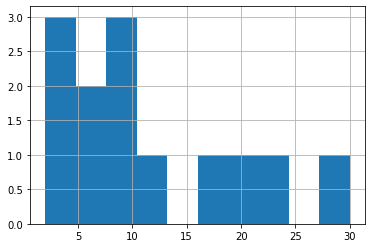

In [ ]:
pd.Series(distances_between_indices_of_tweets_containing_keyword).hist()
plt.savefig('snapshot/lima_tweets_hist.png')

In [ ]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

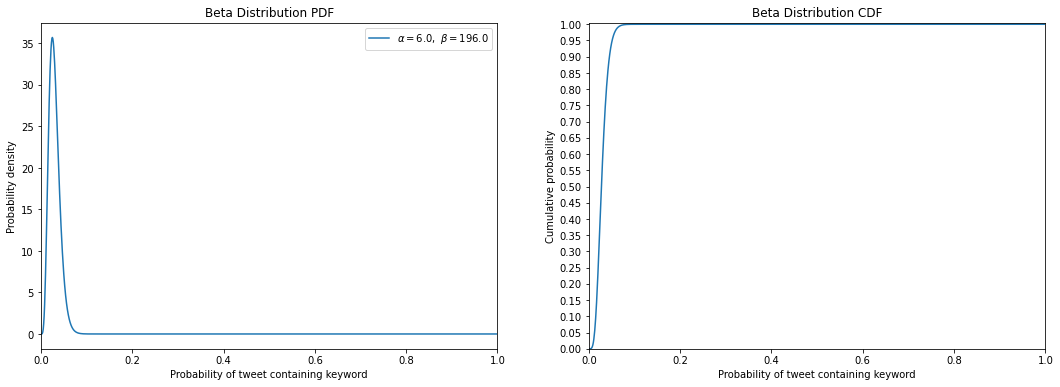

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

plt.subplot(122)
plt.plot(x_values, cdf_y_values)
plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')
plt.savefig('snapshot/Beta Distribution CDF.png');

In [ ]:
ix = [n for n,b in enumerate((cdf_y_values>.5)&(cdf_y_values<.95)) if b]

In [ ]:
range_ =cdf_y_values[ix]

In [ ]:
a=np.c_[x_values[ix],cdf_y_values[ix]]
max_ix,_ = np.unravel_index(a.argmax(), a.shape)
min_ix,_ = np.unravel_index(a.argmin(), a.shape)
fifth_percentile, ninety_fifth_percentile = x_values[max_ix],x_values[min_ix]

In [ ]:
print('Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: {} y {}'.format(
    round(fifth_percentile, 10), round(ninety_fifth_percentile, 10)))

Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: 0.023976024 y 0.000999001


In [ ]:
def compute_total_probability_that_probability_less_than_p(p):
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

print('La probabilidad que la verdadera probabilidad es > .1 es: {}'.format(
    1 - compute_total_probability_that_probability_less_than_p(.1)))

La probabilidad que la verdadera probabilidad es > .1 es: 3.328883511244385e-05


In [ ]:
tweets_has_location_df = tweets_df[tweets_df['location']!='']

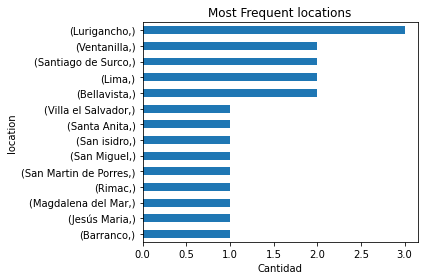

In [ ]:
tweets_has_location_df.value_counts(subset=['location'],ascending=True).plot(kind='barh')
plt.title('Most Frequent locations')
plt.xlabel('Cantidad')
plt.tight_layout()
plt.savefig('snapshot/most Frequent locations.png');

In [ ]:
tweets_df.to_csv('lima_tweets.csv',index=None)
tweets_has_location_df.to_csv('lima_tweets_location.csv',index=None)

In [ ]:
tweets_df = pd.read_csv('lima_tweets.csv')
tweets_has_location_df = pd.read_csv('lima_tweets_location.csv')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('spanish') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
doc_complete = tweets_df.Tweets.values
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   
tweets_df.dropna(inplace=True)

In [ ]:
tweets_df['Tweets_clean'] = pd.Series(doc_clean).apply(lambda x:' '.join(x))
tweets_df['word_count'] = tweets_df['Tweets_clean'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets_clean'].str.len()

In [ ]:
def avg_word(sentence):
    words = sentence.split()
    if len(words)==0:
        return 0
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets_clean'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets_df.head(3)

,date,Tweets,location,followers,word_count,char_count,avg_word,hastags,numerics,Tweets_clean
4,2020-10-09 04:11:20,Poco a poco todo se va acomodando,Santa Anita,170,2,13,6.000000,0,0,va acomodando
11,2020-10-09 04:11:25,"Hay gente que han perdido la vergüenza, preten...",Jesús Maria,51,7,51,6.428571,0,0,gente perdido vergüenza pretender ser candidat...
12,2020-10-09 04:11:25,"Éste Viernes de Sankirtana, nos visita Hanumat...",Lurigancho,401,14,116,7.357143,0,0,éste viernes sankirtana visita hanumat prana d...


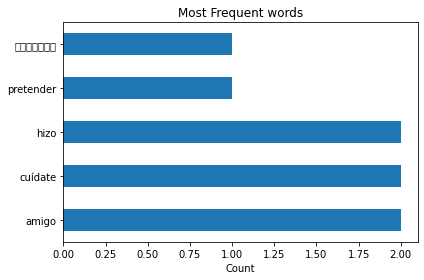

In [ ]:
freq = pd.Series(' '.join(tweets_df['Tweets_clean']).split()).value_counts()[:5]
freq.plot(kind='barh')
plt.title('Most Frequent words')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('snapshot/most Frequent words.png');

In [ ]:
pprint(tweets_df['Tweets_clean'][:2])

4                                         va acomodando
11    gente perdido vergüenza pretender ser candidat...
Name: Tweets_clean, dtype: object


In [ ]:
dictionary = corpora.Dictionary(tweets_df['Tweets_clean'].apply(lambda x:x.split()))
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
pprint(doc_term_matrix[:2])

[[], [(86, 1)]]


In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [ ]:
from pprint import pprint
pprint(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.056*"va" + 0.056*"da" + 0.035*"ser"'),
 (1, '0.061*"gusta" + 0.028*"haciendo" + 0.028*"hizo"'),
 (2, '0.077*"buenas" + 0.056*"noches" + 0.056*"amigo"')]


In [ ]:
# from gensim.test.utils import datapath
# fname = datapath("lda_lima_tweet_model")
ldamodel.save("lda_lima_tweet_model")

In [ ]:
from gensim.models.ldamodel import LdaModel
ldamodel = LdaModel.load("lda_lima_tweet_model")

In [ ]:
doc_lda = ldamodel[doc_term_matrix]

In [ ]:
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better

Perplexity:  -5.379126834037385


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.100282 -0.075889       1        1  41.999370
2     -0.124327 -0.038993       2        1  29.245487
0      0.024046  0.114882       3        1  28.755144, topic_info=       Term      Freq     Total Category  logprob  loglift
119  buenas  4.000000  4.000000  Default  30.0000  30.0000
122  noches  3.000000  3.000000  Default  29.0000  29.0000
1        va  3.000000  3.000000  Default  28.0000  28.0000
54    amigo  3.000000  3.000000  Default  27.0000  27.0000
86    gusta  5.000000  5.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
42      dio  0.732745  1.134113   Topic3  -4.2741   0.8095
41   cólera  0.732745  1.134113   Topic3  -4.2741   0.8095
31   muchas  1.802959  2.873987   Topic3  -3.3737   0.7801
3     gente  0.764516  2.263886   Topic3  -4.2316   0.1608
43     hizo  0.735490  3.044914   Topic3  -4.2704  -0.1743

[127 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
77        3  0.881755      alexis
54        2  0.879114       amigo
23        1  0.818875        anja
78        3  0.881755        aria
55        2  0.870030  aziraphale
...     ...       ...         ...
123       2  0.870027           🌛
124       2  0.870027         👏👏👏
48        2  0.870018           😍
125       2  0.870027           🙏
76        2  0.870024     🤦🏻‍♂️xd

[97 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc_ = nlp(sent)
        texts_out.append(list(set([str(c.head) for c in doc_ if c.head.tag_.startswith(tuple(allowed_postags))])))
    return texts_out

lemmatization(tweets_df['Tweets_clean'][:5],['VERB'])

[['acomodando'], ['pretender'], ['da'], [], ['cuídate']]

In [ ]:
def join_comma(row_list):
    if row_list == []:
        return np.NaN
    else:
        return ', '.join(row_list)

tweets_df['ACTIONS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['VERB'])).apply(join_comma)
tweets_df['NOUNS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['NOUN'])).apply(join_comma)

In [ ]:
tweets_df[['Tweets_clean','NOUNS','ACTIONS']].head()

,Tweets_clean,NOUNS,ACTIONS
4,va acomodando,desgracia,cuídate
11,gente perdido vergüenza pretender ser candidat...,NaN,NaN
12,éste viernes sankirtana visita hanumat prana d...,"piqueos, basura",comer
14,untkcqr emilia14614784 luvwaifus cuídate anja ...,NaN,hagan
33,ohohuh1 cuídate mucho desgracia todo,NaN,NaN


In [ ]:
tweets_df.head()

,date,Tweets,location,followers,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
4,2020-10-09 04:11:20,Poco a poco todo se va acomodando,Santa Anita,170,2,13,6.000000,0,0,va acomodando,cuídate,desgracia
11,2020-10-09 04:11:25,"Hay gente que han perdido la vergüenza, preten...",Jesús Maria,51,7,51,6.428571,0,0,gente perdido vergüenza pretender ser candidat...,NaN,NaN
12,2020-10-09 04:11:25,"Éste Viernes de Sankirtana, nos visita Hanumat...",Lurigancho,401,14,116,7.357143,0,0,éste viernes sankirtana visita hanumat prana d...,comer,"piqueos, basura"
14,2020-10-09 04:11:27,@UnTkCqr @Emilia14614784 @LuvWaifus Cuídate mu...,Villa el Salvador,371,13,107,7.307692,0,0,untkcqr emilia14614784 luvwaifus cuídate anja ...,hagan,NaN
33,2020-10-09 04:11:43,"@ohohuh1 :( cuídate mucho.\n\nQué desgracia, t...",Magdalena del Mar,196,5,36,6.400000,0,0,ohohuh1 cuídate mucho desgracia todo,NaN,NaN


In [ ]:
tweets_df.to_csv('tweets_solutions.csv',index=None)

In [ ]:
tweets_df = pd.read_csv('tweets_solutions.csv')
tweets_df.dropna(inplace=True)

In [ ]:
tweets_df['Tweets_clean']

0                                        va acomodando
2    éste viernes sankirtana visita hanumat prana d...
Name: Tweets_clean, dtype: object

In [ ]:
tweets_df['Tweets_clean'] = tweets_df['Tweets_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(tweets_df.shape)
tweets_df['Tweets_clean'].head()

(2, 12)


0                                        va acomodando
2    éste viernes sankirtana visita hanumat prana d...
Name: Tweets_clean, dtype: object

In [ ]:
# displacy.serve(doc, style="dep")

In [ ]:
doc = nlp(tweets_df['Tweets_clean'].iloc[-1])
from IPython.display import HTML, Image, display
displacy.render(doc, style="dep",jupyter=True,options={'distance':100})

In [ ]:
displacy.render(doc, style="ent",jupyter=True,)

In [ ]:
TextBlob(tweets_df['Tweets_clean'].iloc[-1]).ngrams(2)

[WordList(['éste', 'viernes']),
 WordList(['viernes', 'sankirtana']),
 WordList(['sankirtana', 'visita']),
 WordList(['visita', 'hanumat']),
 WordList(['hanumat', 'prana']),
 WordList(['prana', 'da']),
 WordList(['da', 'gran']),
 WordList(['gran', 'entusiasta']),
 WordList(['entusiasta', 'sankirtanero']),
 WordList(['sankirtanero', 'perú']),
 WordList(['perú', 'méxico']),
 WordList(['méxico', 'colombi…']),
 WordList(['colombi…', 'httpstco4hqv9gupmk'])]

In [ ]:
tf1 = (tweets_df['Tweets_clean']).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(tweets_df.shape[0]/(len(tweets_df[tweets_df['Tweets_clean'].str.contains(word)])))

tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1.shape)
tf1.head(10)

(16, 4)


,words,tf,idf,tfidf
0,acomodando,1.0,0.693147,0.693147
1,va,1.0,0.693147,0.693147
2,perú,1.0,0.693147,0.693147
3,gran,1.0,0.693147,0.693147
4,sankirtanero,1.0,0.693147,0.693147
5,da,1.0,0.000000,0.000000
6,méxico,1.0,0.693147,0.693147
7,hanumat,1.0,0.693147,0.693147
8,éste,1.0,0.693147,0.693147
9,colombi…,1.0,0.693147,0.693147


In [ ]:
stop = set(stopwords.words('spanish'))
stop |= set(['lima','si','ser'])

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= stop,ngram_range=(1,1))
train_vect = tfidf.fit_transform(tweets_df['Tweets_clean'])
train_vect

<2x16 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(tweets_df['Tweets_clean'])
print(train_bow.shape)
train_bow

(2, 16)


<2x16 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [ ]:
tweet = tweets_df.sample(1)
tweet

,date,Tweets,location,followers,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
2,2020-10-09 04:11:25,"Éste Viernes de Sankirtana, nos visita Hanumat...",Lurigancho,401,14,116,7.357143,0,0,éste viernes sankirtana visita hanumat prana d...,comer,"piqueos, basura"


In [ ]:
print(tweet['Tweets'].values)

['Éste Viernes de Sankirtana, nos visita Hanumat Prana Das, un gran y entusiasta sankirtanero. \nPerú /México /Colombi… https://t.co/4hqv9gupmK']


In [ ]:
tweet.reset_index(drop=True,inplace=True)

In [ ]:
pd.options.display.max_colwidth = 120
vals = pd.DataFrame()
for index, score in find_similar(train_vect, tweet.index[0],top_n = 5):
    vals = vals.append(tweets_df.iloc[index:index+1,:])
    vals.loc[index,'score'] = score
    
vals[['Tweets','score']].head()

,Tweets,score
2,"Éste Viernes de Sankirtana, nos visita Hanumat Prana Das, un gran y entusiasta sankirtanero. \nPerú /México /Colombi...",NaN
1,NaN,0.0


In [ ]:
corpus = nlp('\n'.join(tweets_df['NOUNS'].dropna()))

In [ ]:
visited = {}
nouns = []
for word in corpus:
    if word.pos_.startswith('N') and len(word.string) < 15 and len(word.string) > 2:
        token = word.string.strip().lower()
        if token in visited:
            visited[token] += 1
            continue
        else:
            visited[token] = 1
            nouns.append(word)
nouns = sorted(nouns, key=lambda w: -visited[w.string.strip().lower()])[:150]
pd.DataFrame([[w.text, visited[w.string.strip().lower()]] for w in nouns], columns=['Noun', 'Freq'])

,Noun,Freq
0,desgracia,1
1,piqueos,1
2,basura,1


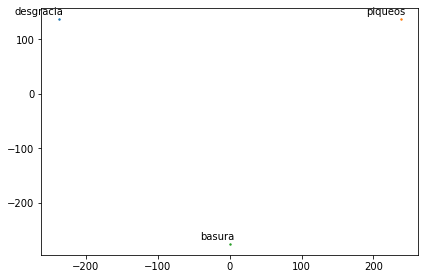

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure() # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, s=2.0)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',ha='right',va='bottom')
    plt.tight_layout()
    plt.savefig('snapshot/lima_words_TSNE.png')
    plt.show()

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=50.0, n_components=2, init='pca', n_iter=10000)

low_dim_embedding = tsne.fit_transform(np.array([word.vector for word in nouns]))

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, [word.text for word in nouns])

In [ ]:
tweets_df = pd.read_csv('tweets_solutions.csv')
tweets_df.head(1)

,date,Tweets,location,followers,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
0,2020-10-09 04:11:20,Poco a poco todo se va acomodando,Santa Anita,170,2,13,6.0,0,0,va acomodando,cuídate,desgracia


In [ ]:
hashtag_summary = adv.extract_hashtags(tweets_df['Tweets'])
hashtag_summary.keys()

dict_keys(['hashtags', 'hashtags_flat', 'hashtag_counts', 'hashtag_freq', 'top_hashtags', 'overview'])

In [ ]:
hashtag_summary['overview']

{'hashtags_per_post': 0.0,
 'num_hashtags': 0,
 'num_posts': 20,
 'unique_hashtags': 0}

In [ ]:
hashtag_summary['hashtags'][:5]

[[], [], [], [], []]

In [ ]:
hashtag_summary['hashtag_counts'][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
hashtag_summary['hashtag_freq'][:20]

[(0, 20)]

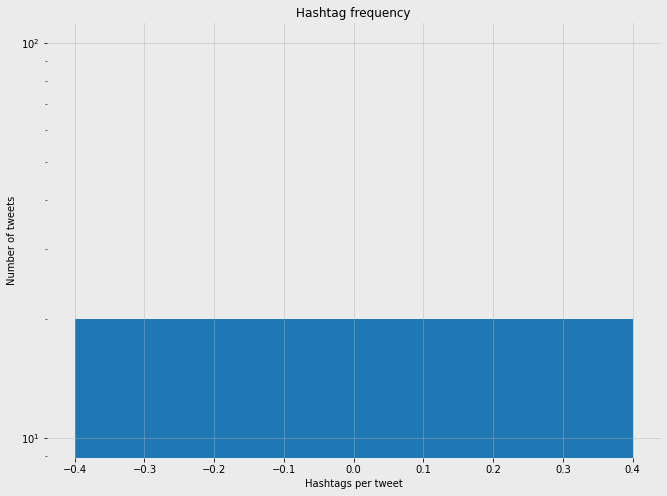

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(11, 8))
plt.bar([x[0] for x in hashtag_summary['hashtag_freq'][:15]],
        [x[1] for x in hashtag_summary['hashtag_freq'][:15]])
plt.title('Hashtag frequency')
plt.xlabel('Hashtags per tweet')
plt.ylabel('Number of tweets')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [ ]:
hashtag_summary['top_hashtags'][:10]

[]

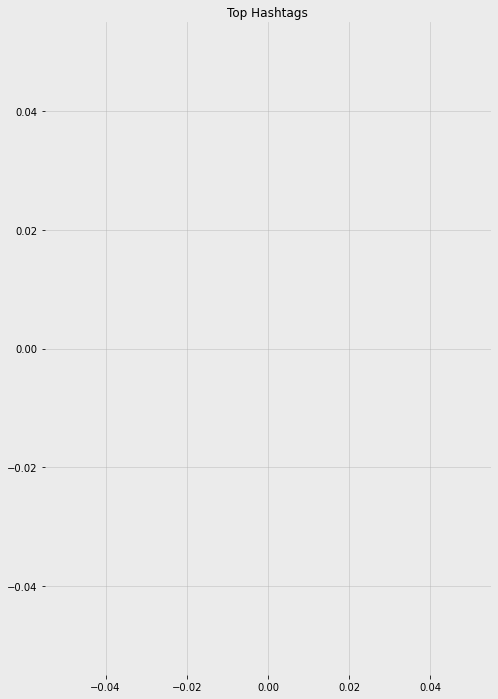

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(8, 12))
plt.barh([x[0] for x in hashtag_summary['top_hashtags'][2:][:5]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][2:][:5]][::-1])
plt.title('Top Hashtags')
# plt.xticks(range(3))
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [ ]:
emoji_summary = adv.extract_emoji(tweets_df['Tweets'])
emoji_summary.keys()

dict_keys(['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text', 'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'top_emoji_groups', 'top_emoji_sub_groups', 'overview'])

In [ ]:
emoji_summary['overview']

{'emoji_per_post': 1.15, 'num_emoji': 23, 'num_posts': 20, 'unique_emoji': 14}

In [ ]:
emoji_summary['emoji'][50:80]

[]

In [ ]:
emoji_summary['emoji_text'][50:80]

[]

In [ ]:
emoji_summary['emoji_flat'][:10]

['😍', '\U0001f97a', '🙏', '🍔', '😋', '🤣', '🤣', '🤣', '🤣', '🤣']

In [ ]:
emoji_summary['emoji_flat_text'][:10]

['smiling face with heart-eyes',
 'pleading face',
 'folded hands',
 'hamburger',
 'face savoring food',
 'rolling on the floor laughing',
 'rolling on the floor laughing',
 'rolling on the floor laughing',
 'rolling on the floor laughing',
 'rolling on the floor laughing']

In [ ]:
list(zip(emoji_summary['emoji_flat'][:10], emoji_summary['emoji_flat_text'][:10]))

[('😍', 'smiling face with heart-eyes'),
 ('\U0001f97a', 'pleading face'),
 ('🙏', 'folded hands'),
 ('🍔', 'hamburger'),
 ('😋', 'face savoring food'),
 ('🤣', 'rolling on the floor laughing'),
 ('🤣', 'rolling on the floor laughing'),
 ('🤣', 'rolling on the floor laughing'),
 ('🤣', 'rolling on the floor laughing'),
 ('🤣', 'rolling on the floor laughing')]

In [ ]:
emoji_summary['emoji_counts'][:15]

[0, 0, 0, 0, 0, 0, 1, 4, 0, 7, 1, 0, 1, 2, 0]

In [ ]:
emoji_summary['emoji_freq'][:15]

[(0, 12), (1, 3), (2, 2), (4, 1), (5, 1), (7, 1)]

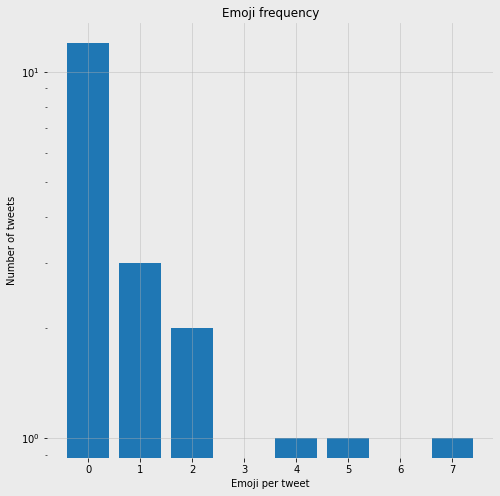

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.bar([x[0] for x in emoji_summary['emoji_freq'][:15]],
        [x[1] for x in emoji_summary['emoji_freq'][:15]])
plt.title('Emoji frequency')
plt.xlabel('Emoji per tweet')
plt.ylabel('Number of tweets')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [ ]:
emoji_summary['top_emoji'][:8]

[('🤣', 7),
 ('👏', 3),
 ('🙏', 2),
 ('😍', 1),
 ('\U0001f97a', 1),
 ('🍔', 1),
 ('😋', 1),
 ('🤦🏻\u200d♂️', 1)]

In [ ]:
emoji_summary['top_emoji_text'][:8]

[('rolling on the floor laughing', 7),
 ('clapping hands', 3),
 ('folded hands', 2),
 ('smiling face with heart-eyes', 1),
 ('pleading face', 1),
 ('hamburger', 1),
 ('face savoring food', 1),
 ('man facepalming: light skin tone', 1)]

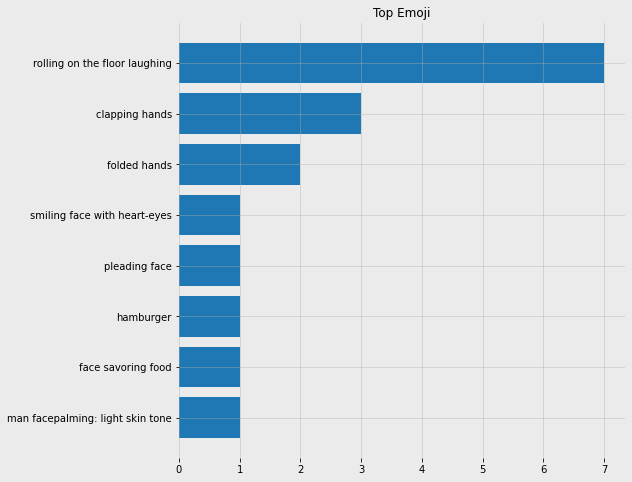

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.barh([x[0] for x in emoji_summary['top_emoji_text'][:8]][::-1],
         [x[1] for x in emoji_summary['top_emoji_text'][:8]][::-1])
plt.title('Top Emoji')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [ ]:
mention_summary = adv.extract_mentions(tweets_df.Tweets)
mention_summary.keys()

dict_keys(['mentions', 'mentions_flat', 'mention_counts', 'mention_freq', 'top_mentions', 'overview'])

In [ ]:
mention_summary['overview']

{'mentions_per_post': 0.85,
 'num_mentions': 17,
 'num_posts': 20,
 'unique_mentions': 17}

In [ ]:
mention_summary['mentions'][:15]

[[],
 [],
 [],
 ['@untkcqr', '@emilia14614784', '@luvwaifus'],
 ['@ohohuh1'],
 ['@sobrinov_edu'],
 ['@alelegabi'],
 ['@gordoomx'],
 [],
 [],
 ['@melody260515'],
 ['@daniloruiz1924', '@universitario'],
 [],
 [],
 ['@cin_deli']]

In [ ]:
mention_summary['mentions_flat'][:10]

['@untkcqr',
 '@emilia14614784',
 '@luvwaifus',
 '@ohohuh1',
 '@sobrinov_edu',
 '@alelegabi',
 '@gordoomx',
 '@melody260515',
 '@daniloruiz1924',
 '@universitario']

In [ ]:
mention_summary['mention_counts'][:20]

[0, 0, 0, 3, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 1, 1]

In [ ]:
mention_summary['mention_freq'][:15]

[(0, 8), (1, 8), (2, 3), (3, 1)]

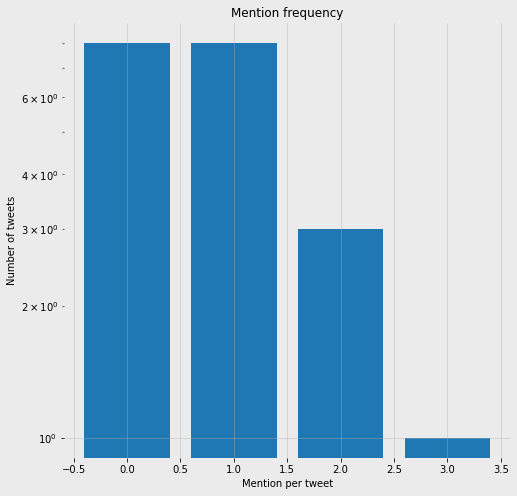

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.bar([x[0] for x in mention_summary['mention_freq'][:15]],
        [x[1] for x in mention_summary['mention_freq'][:15]])
plt.title('Mention frequency')
plt.xlabel('Mention per tweet')
plt.ylabel('Number of tweets')
plt.grid(alpha=0.5)
plt.yscale('log')
plt.gca().set_frame_on(False)
plt.savefig('snapshot/Mention Frequency.png');

In [ ]:
mention_summary['top_mentions'][:10]

[('@untkcqr', 1),
 ('@emilia14614784', 1),
 ('@luvwaifus', 1),
 ('@ohohuh1', 1),
 ('@sobrinov_edu', 1),
 ('@alelegabi', 1),
 ('@gordoomx', 1),
 ('@melody260515', 1),
 ('@daniloruiz1924', 1),
 ('@universitario', 1)]

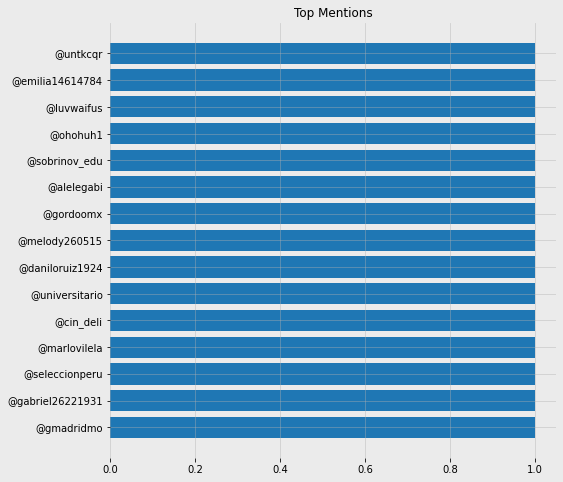

In [ ]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.barh([x[0] for x in mention_summary['top_mentions'][:15]][::-1],
         [x[1] for x in mention_summary['top_mentions'][:15]][::-1])
plt.title('Top Mentions')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)
plt.savefig('snapshot/Top Mentions.png');

In [ ]:
tweets_df.columns

Index(['date', 'Tweets', 'location', 'followers', 'word_count', 'char_count',
       'avg_word', 'hastags', 'numerics', 'Tweets_clean', 'ACTIONS', 'NOUNS'],
      dtype='object')

In [ ]:
extracted_tweets =  (tweets_df[['Tweets', 'followers']]
 .assign(hashtags=hashtag_summary['hashtags'],
         hashcounts=hashtag_summary['hashtag_counts'],
         mentions=mention_summary['mentions'],
         mention_count=mention_summary['mention_counts'],
         emoji=emoji_summary['emoji'],
         emoji_text=emoji_summary['emoji_text'],
         emoji_count=emoji_summary['emoji_counts'],))
extracted_tweets.head()

,Tweets,followers,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count
0,Poco a poco todo se va acomodando,170,[],0,[],0,[],[],0
1,"Hay gente que han perdido la vergüenza, pretender ser candidato de UPP.",51,[],0,[],0,[],[],0
2,"Éste Viernes de Sankirtana, nos visita Hanumat Prana Das, un gran y entusiasta sankirtanero. \nPerú /México /Colombi...",401,[],0,[],0,[],[],0
3,@UnTkCqr @Emilia14614784 @LuvWaifus Cuídate mucho Anja. Recuerda que Emilia es la Best Girl de Re:Zero por muchas r…...,371,[],0,"[@untkcqr, @emilia14614784, @luvwaifus]",3,[],[],0
4,"@ohohuh1 :( cuídate mucho.\n\nQué desgracia, todo...",196,[],0,[@ohohuh1],1,[],[],0


In [ ]:
extracted_tweets.columns

Index(['Tweets', 'followers', 'hashtags', 'hashcounts', 'mentions',
       'mention_count', 'emoji', 'emoji_text', 'emoji_count'],
      dtype='object')

In [ ]:
word_freq_hash = adv.word_frequency(extracted_tweets['hashtags'].str.join(' '), 
                                    extracted_tweets['followers'].fillna(0))#.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_hash.head(10)

,word,abs_freq,wtd_freq,rel_value


In [ ]:
extracted_tweets[extracted_tweets['hashtags'].str.join(' ')
                  .str.contains('lima',case=False)]

,Tweets,followers,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count


In [ ]:
word_freq_mention = adv.word_frequency(extracted_tweets['mentions'].str.join(' '), 
                                       extracted_tweets['followers'].fillna(0))
                                    #.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_mention.head(10)

,word,abs_freq,wtd_freq,rel_value
0,@daniloruiz1924,1,6014,6014.0
1,@universitario,1,6014,6014.0
2,@gordoomx,1,2161,2161.0
3,@manago72,1,2161,2161.0
4,@emilia14614784,1,371,371.0
5,@untkcqr,1,371,371.0
6,@luvwaifus,1,371,371.0
7,@marlovilela,1,329,329.0
8,@seleccionperu,1,329,329.0
9,@ohohuh1,1,196,196.0


In [ ]:
word_freq_emoji = adv.word_frequency(extracted_tweets['emoji'].str.join(' '), 
                                       extracted_tweets['followers'].fillna(0))#.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_emoji.head(10)

,word,abs_freq,wtd_freq,rel_value
0,👏,3,6483,2161.0
1,🙏,2,4322,2161.0
2,🥺,1,2161,2161.0
3,🍔,1,2161,2161.0
4,😋,1,2161,2161.0
5,🌛,1,2161,2161.0
6,🤣,7,1946,278.0
7,😍,1,155,155.0
8,🤦🏻‍♂️,1,136,136.0
9,😪,1,135,135.0


In [ ]:
[adv.extract_emoji(k)['emoji_flat_text'][0] for k in word_freq_emoji['word'][:10]]

['clapping hands',
 'folded hands',
 'pleading face',
 'hamburger',
 'face savoring food',
 'first quarter moon face',
 'rolling on the floor laughing',
 'smiling face with heart-eyes',
 'person facepalming',
 'sleepy face']

In [ ]:
word_freq_emoji[:10].assign(emoji_text=[adv.extract_emoji(k)['emoji_flat_text'][0] for k in word_freq_emoji['word'][:10]])

,word,abs_freq,wtd_freq,rel_value,emoji_text
0,👏,3,6483,2161.0,clapping hands
1,🙏,2,4322,2161.0,folded hands
2,🥺,1,2161,2161.0,pleading face
3,🍔,1,2161,2161.0,hamburger
4,😋,1,2161,2161.0,face savoring food
5,🌛,1,2161,2161.0,first quarter moon face
6,🤣,7,1946,278.0,rolling on the floor laughing
7,😍,1,155,155.0,smiling face with heart-eyes
8,🤦🏻‍♂️,1,136,136.0,person facepalming
9,😪,1,135,135.0,sleepy face


In [ ]:
sotu_retweets = np.load('tweets_dict.npy',allow_pickle=True)

In [ ]:
def buildDataFrameFromDict(mapping):
    df=[]
    for f in mapping:
        f_n = {}
        for k,item in f.items():
            if isinstance(item,dict):
                for i,j in item.items():
                    f_n[k+'-'+i] = j
            else:
                f_n[k] = f[k]
        df.append(f_n)
    
    df = pd.DataFrame(df)
    return df

sotu = buildDataFrameFromDict(sotu_retweets)
sotu.head(3)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user-id,user-id_str,user-name,user-screen_name,user-location,user-url,user-description,user-translator_type,user-protected,user-verified,user-followers_count,user-friends_count,user-listed_count,user-favourites_count,user-statuses_count,user-created_at,user-utc_offset,user-time_zone,user-geo_enabled,user-lang,user-contributors_enabled,user-is_translator,user-profile_background_color,user-profile_background_image_url,user-profile_background_image_url_https,user-profile_background_tile,user-profile_link_color,user-profile_sidebar_border_color,user-profile_sidebar_fill_color,...,quoted_status-is_quote_status,quoted_status-quote_count,quoted_status-reply_count,quoted_status-retweet_count,quoted_status-favorite_count,quoted_status-entities,quoted_status-favorited,quoted_status-retweeted,quoted_status-filter_level,quoted_status-lang,quoted_status_permalink-url,quoted_status_permalink-expanded,quoted_status_permalink-display,quoted_status-extended_tweet,quoted_status-possibly_sensitive,display_text_range,extended_tweet-full_text,extended_tweet-display_text_range,extended_tweet-entities,possibly_sensitive,retweeted_status-extended_entities,entities-media,extended_entities-media,quoted_status-extended_entities,quoted_status-quoted_status_id,quoted_status-quoted_status_id_str,extended_tweet-extended_entities,place-id,place-url,place-place_type,place-name,place-full_name,place-country_code,place-country,place-bounding_box,place-attributes,geo-type,geo-coordinates,coordinates-type,coordinates-coordinates
0,Fri Oct 09 03:56:50 +0000 2020,1314414491648565248,1314414491648565248,RT @lovtyholic: ‼️‼️ayuden a reportar esta cuenta NO INTERACTUAR NO CITAR NO RESPONDER solo reporten el tweet y la c...,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,None,NaN,None,None,3276878238,3276878238,HELLO JONGDAE 𐂅,moonsootyong,None,https://invisiblestring.carrd.co,#도경수 🐧 -108 ۵she/her۵MoonDanSe|Tyongf♥️ #문태일 #태용 #정한 #เตนล์ ...,none,False,False,143,198,3,90612,20735,Sun Jul 12 01:50:27 +0000 2015,None,None,False,None,False,False,000000,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,F58EA8,000000,000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fri Oct 09 03:56:50 +0000 2020,1314414494039314432,1314414494039314432,¿qué hora es en su país cuando ven este tweet??? aquí son las 10:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,NaN,None,NaN,None,None,1230697673105133570,1230697673105133570,𝐋𝐢𝐬𝐚 ♡𝐀𝐑𝐌𝐘,Winter_bear1997,None,None,𝑌𝑜𝑢’𝑣𝑒 𝑠𝘩𝑜𝑤𝑛 𝑚𝑒 𝐼 𝘩𝑎𝑣𝑒 𝑟𝑒𝑎𝑠𝑜𝑛𝑠 𝐼 𝑠𝘩𝑜𝑢𝑙𝑑 𝑙𝑜𝑣𝑒 𝑚𝑦𝑠𝑒𝑙f 𝐎𝐓𝟕 𝐒𝐭𝐚𝐧 𝐹𝑎𝑛 𝑎𝑐𝑐𝑜𝑢𝑛𝑡,none,False,False,3503,1969,35,13784,8151,Fri Feb 21 03:36:22 +0000 2020,None,None,False,None,False,False,F5F8FA,,,False,1DA1F2,C0DEED,DDEEF6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fri Oct 09 03:56:51 +0000 2020,1314414496002322432,1314414496002322432,RT @Juuandedios_p: Este tweet podra llegar a 500 comentarios con la siguiente frase:\n\nCANCIONES PARA MI EX\n\n15 c...,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,None,NaN,None,None,1268048343202009088,1268048343202009088,𝙚𝙙𝙖🦋,edaloveskenia,None,None,•𝐜𝐮𝐞𝐧𝐭𝐚 𝐩𝐚𝐫𝐚 𝐯𝐨𝐭𝐨𝐬•\n𝐜𝐮𝐞𝐧𝐭𝐚 𝐩𝐫𝐢𝐧𝐜𝐢𝐩𝐚𝐥: @edapdc1\n 𝐟𝐚𝐧 𝐚𝐜𝐜𝐨𝐮𝐧𝐭,none,False,False,107,136,0,80,3584,Wed Jun 03 05:14:31 +0000 2020,None,None,False,None,False,False,F5F8FA,,,False,1DA1F2,C0DEED,DDEEF6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
pprint(sotu.columns.values)

array(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user-id', 'user-id_str', 'user-name',
       'user-screen_name', 'user-location', 'user-url',
       'user-description', 'user-translator_type', 'user-protected',
       'user-verified', 'user-followers_count', 'user-friends_count',
       'user-listed_count', 'user-favourites_count',
       'user-statuses_count', 'user-created_at', 'user-utc_offset',
       'user-time_zone', 'user-geo_enabled', 'user-lang',
       'user-contributors_enabled', 'user-is_translator',
       'user-profile_background_color',
       'user-profile_background_image_url',
       'user-profile_background_image_url_https',
       'user-profile_background_tile', 'user-profile_link_color',
       'user-profile_sidebar_border_color',
       'user-profile_sidebar_fill_color', 'user-profile_text_colo

In [ ]:
data = sotu.sample(10)['user-screen_name']
sotu['retweeted_status-user-screen_name'] = np.random.choice(data,len(sotu))

In [ ]:
sotu[['user-screen_name','retweeted_status-user-screen_name']].head()

,user-screen_name,retweeted_status-user-screen_name
0,moonsootyong,whotamelonsugar
1,Winter_bear1997,YoceOs
2,edaloveskenia,Constanpr
3,LeeBer37753434,leonXD__
4,FelipeCucalon,Michi_Ca_Pin


In [ ]:
G_rt = nx.from_pandas_edgelist(
    sotu,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
    
print('Nodes in RT network:', len(G_rt.nodes()))
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 589
Edges in RT network: 609


In [ ]:
G_reply = nx.from_pandas_edgelist(
    sotu,
    source = 'user-screen_name', 
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())
    
print('Nodes in reply network:', len(G_reply.nodes()))

print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 749
Edges in reply network: 598


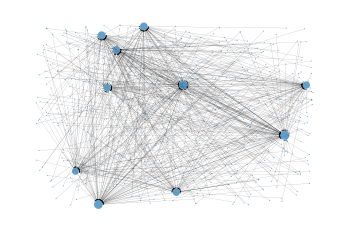

In [ ]:
pos = nx.random_layout(G_rt)

sizes = [x[1] for x in G_rt.degree()]

nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.savefig('snapshot/lima_tweets_influencing_graph.png')
plt.axis('off'); plt.show()

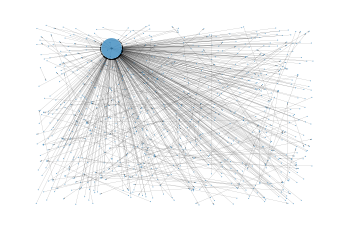

In [ ]:
pos = nx.random_layout(G_reply)
sizes = [x[1] for x in G_reply.degree()]

nx.draw_networkx(G_reply, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.axis('off'); plt.show()

In [ ]:
column_names = ['screen_name', 'degree_centrality']
rt_centrality = nx.in_degree_centrality(G_rt)

reply_centrality = nx.in_degree_centrality(G_reply)

rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

display(rt.sort_values('degree_centrality', ascending = False).head())

display(reply.sort_values('degree_centrality', ascending = False).head())

,screen_name,degree_centrality
14,corzin443,0.134354
7,leonXD__,0.127551
1,whotamelonsugar,0.119048
5,Constanpr,0.103741
34,Danna_ArdilaO,0.102041


,screen_name,degree_centrality
1,None,0.570856
111,leoni70803995,0.002674
369,lovely_min_k,0.002674
546,jmvalerapiedras,0.002674
62,jimenaajimenezr,0.002674


In [ ]:
column_names = ['screen_name', 'betweenness_centrality']
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
display(rt.sort_values('betweenness_centrality', ascending = False).head())

# Print first five results in descending order of centrality
display(reply.sort_values('betweenness_centrality', ascending = False).head())

,screen_name,betweenness_centrality
14,corzin443,0.004016
51,kmiilinn,0.002161
9,Michi_Ca_Pin,0.001792
1,whotamelonsugar,0.001751
28,Crackalaka2,0.001686


,screen_name,betweenness_centrality
261,rosamt5,0.000002
509,stigmxjk,0.000002
76,LuSKabeche,0.000002
0,moonsootyong,0.000000
502,Castelopio,0.000000


In [ ]:
column_names = ['screen_name', 'degree']

degree_rt = pd.DataFrame(list(G_rt.in_degree()), columns = column_names)
degree_reply = pd.DataFrame(list(G_reply.in_degree()), columns = column_names)

ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))

ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

ratio = ratio[ratio['degree_rt'] >= 5]

display(ratio.sort_values('ratio', ascending = False).head())

,screen_name,degree_rt,degree_reply,ratio
14,corzin443,79,1,0.012658
1,whotamelonsugar,70,0,0.000000
3,YoceOs,51,0,0.000000
5,Constanpr,61,0,0.000000
7,leonXD__,75,0,0.000000


```py
!jupyter nbconvert --to html {FILE_HTML_nb} --output {FILE_HTML}
with open(FILE_HTML, 'r') as file:
    content = file.read()
content = content.replace("div.input_area {","div.input_area {\n\tdisplay: none;")    
content = content.replace(".prompt {",".prompt {\n\tdisplay: none;")
f = open(FILE_HTML, 'w')
f.write(content)
f.close()
```